In [344]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivative of a function with single input

In [345]:
def f(x):
    """ scalar value polynomial"""
    return 3*x**2 - 4*x + 5

In [346]:
f(3.0)

20.0

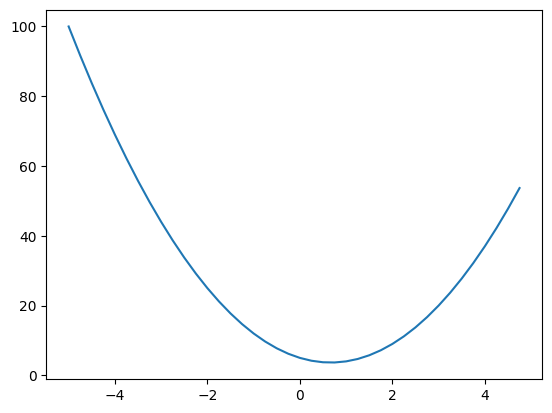

In [347]:
xs  = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Now, we're going to compute the derivative/slope/response.



In [348]:
# using finite-differences approach
h = 1e-15
x = -3.0
f(x+h)
slope = (f(x+h) - f(x))/h
print(f"slope: {slope}")

slope: -14.210854715202002


## Derivative of function with multiple inputs (n-dimensions)

In [349]:
# we're going more complex now.  Multiple inputs

h = 1e-3

#inputs
a = 2.0
b = -3.0
c  =10.0

d1 = a*b + c
# a += h #increase a now 
b += h
d2 = a*b + c

print ("d1: ", d1)
print ("d2: ", d2)
print("slope: ", (d2 - d1)/h ) # this proves our answer is approximating the true value,
                               # since analytically we know the derivative of the function with respect to a is b = -3.0

d1:  4.0
d2:  4.002
slope:  1.9999999999997797


# The Value object: keeping track of operations

In [350]:
from typing import Tuple

class Value:
    def __init__(self, data: float, _children: Tuple = (), _op : str = '', label : str = ''):
        self.data = data
        self._prev = set(_children) # two children that led to the value
        self._op = _op # what operations created this value
        self.label = label
        self.grad = 0 # at initialization, we assume the variable does NOT affect the last value at all

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other : 'Value') -> 'Value':
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other: 'Value') -> 'Value':
        return Value(self.data*other.data, (self,other), '*')
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        return out
    
    

In [351]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e  = a*b; e.label = 'e'

d = e + c; d.label = 'd'

f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'


In [352]:
print("children values: ", d._prev) # children that created the value
print("operation that led to it: ", d._op)

children values:  {Value(data=10.0), Value(data=-6.0)}
operation that led to it:  +


In [353]:
from graphviz import Digraph

def trace(root):
    """
    Traces the operations tree starting from the root node and builds a set of all nodes and edges in the graph.

    Parameters:
    root (Node): The root node of the operations tree.

    Returns:
    tuple: A tuple containing two sets - `nodes` and `edges`. `nodes` is a set of all nodes in the graph, 
           and `edges` is a set of all edges in the graph.
    """

    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            # loop over children and add them as well
            for child in v._prev:
                edges.add((child,v))
                build(child) # recursively explore the operations tree
    
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    Creates a graph visualization of a computational graph rooted at the given node.

    Args:
        root: The root node of the computational graph.

    Returns:
        A graph object representing the computational graph.

    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'UD'})  # build Left to Right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))  # unique identifier for node
        dot.node(name=uid, label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f} ", shape='record')

        if n._op:  # if this node is a result of some operation, create a rectangular record note for said operation
            dot.node(name=uid + n._op, label=n._op)
            # connect this node to operation
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot



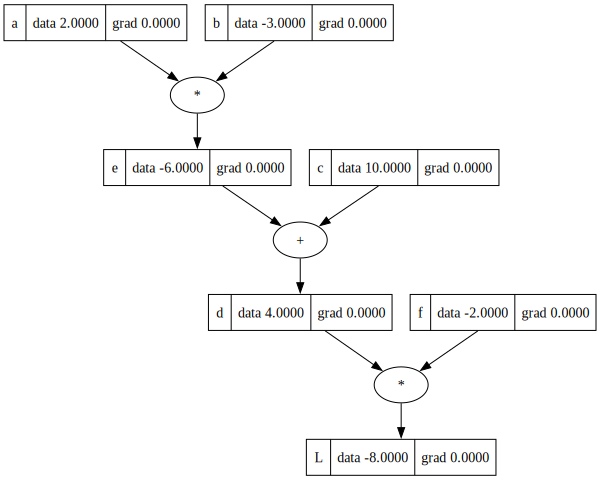

In [354]:
draw_dot(L)

## manual (and finit-difference) gradient calculation for the loss function

In [355]:
def lol():
    # finite-difference
    h = 1e-5

    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    c = Value(10.0, label = 'c')
    e  = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L1 = L.data


    a = Value(2.0, label = 'a')
    b = Value(-3.0, label = 'b')
    b.data += h
    c = Value(10.0, label = 'c')
    e  = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label = 'f')
    L = d*f; L.label = 'L'
    L2 = L.data
    print (L1, L2, h)

    print((L2 - L1)/h)

lol()


-8.0 -8.00004 1e-05
-4.000000000026205


In [356]:
L.grad = 1.0
d.grad = -2.0
f.grad = 4.0
c.grad = -2.0 # dL/dd * dd/dc = -2.0*1.0
e.grad = -2.0 # dL/dd * dd/de = -2.0*1.0

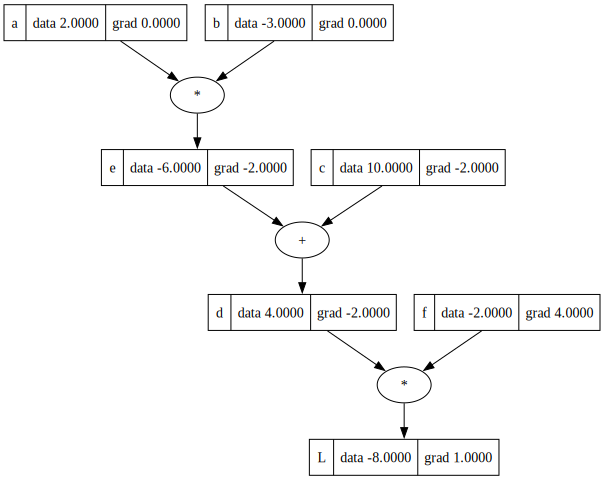

In [357]:
draw_dot(L)

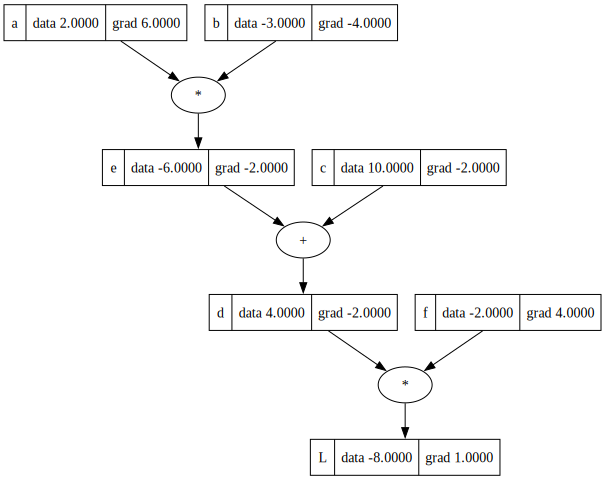

In [358]:
a.grad = 6.0 # dL/da = dL/de*de/da = -2.00*b = 6.00
b.grad = -4.0 # dL/db = dL/de*de/db = -2.00*a = -4.00

draw_dot(L)

now, we node our inputs to make L go up (i.e, going in the direction fo the gradient)

In [359]:
step_size = 0.01

a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

e = a*b
d = e + c
L = d*f


print(L)

Value(data=-7.286496)


## Manual backpropagation 2: Neuron

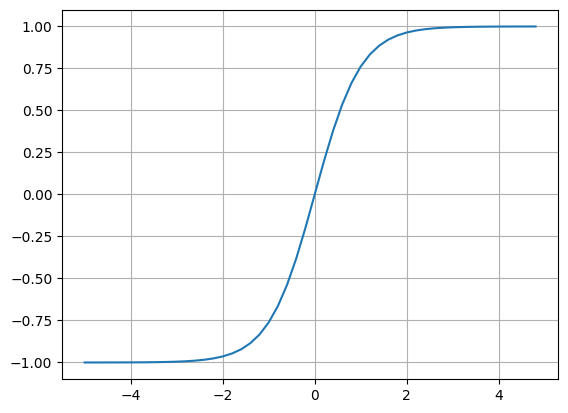

In [360]:
# activation function : tanh

plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

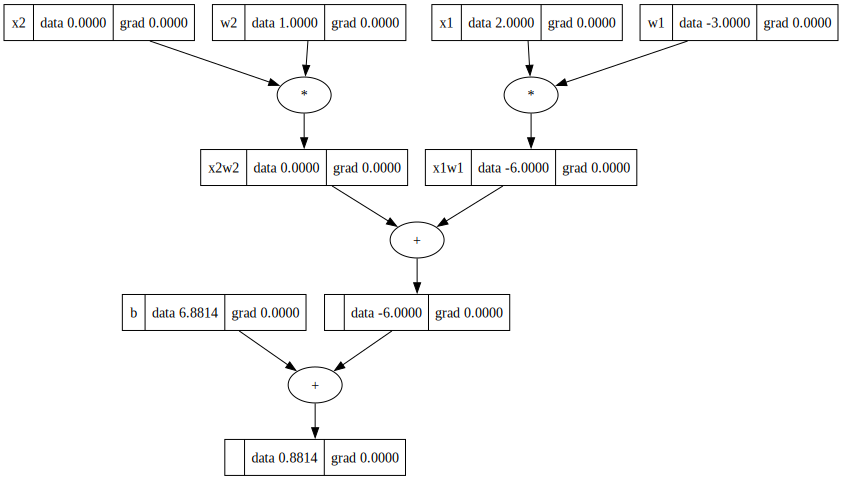

In [361]:
# the neuron

# two inputs: x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

# activation weigthsL w1 , w2
w1 = Value(-3.0, label ='w1')
w2 = Value(1.0, label ='w2')

# bias of the neuron
b = Value(6.88137358, label = 'b')

# operations: x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; label = 'x1w1x2w2'
n = x1w1x2w2 + b; label = 'n'

draw_dot(n)

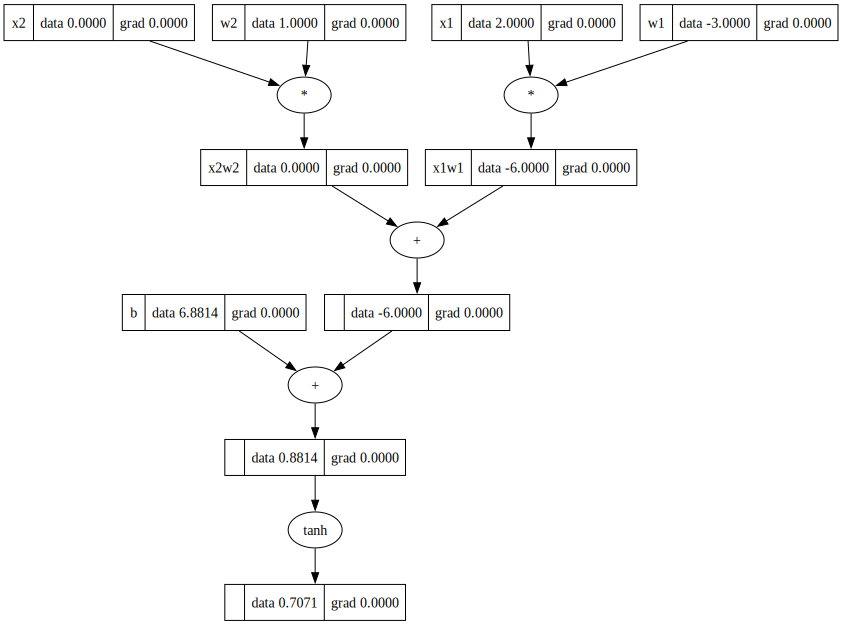

In [362]:
o = n.tanh()
draw_dot(o)

In [363]:
# do/dn = 1 - tanh(n)**2 = 1 - o**2
1 - o.data**2

0.5000000049635664

## automating backpropagation by implementing the backward function for each operation

In [364]:
from __future__ import annotations
from typing import Callable, Tuple, Set, Union

class Value:
    def __init__(self, data: float, _children: Tuple[Value] = (), _op : str = '', label : str = ''):
        self.data = data
        self._prev = set(_children) # two children that led to the value
        self._op = _op # what operations created this value
        self.label = label
        self.grad = 0.0 # at initialization, we assume the variable does NOT affect the last value at all
        self._backward = lambda : None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Value) -> Value:
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        return out

    def __mul__(self, other: Value) -> Value:
        out = Value(self.data*other.data, (self,other), '*')
        def _backward(): # define backprop step for multiplication
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self) -> Value:
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self) -> None:
        topo = []
        visited = set()

        def build_topo(v: Value) -> None:
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [365]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

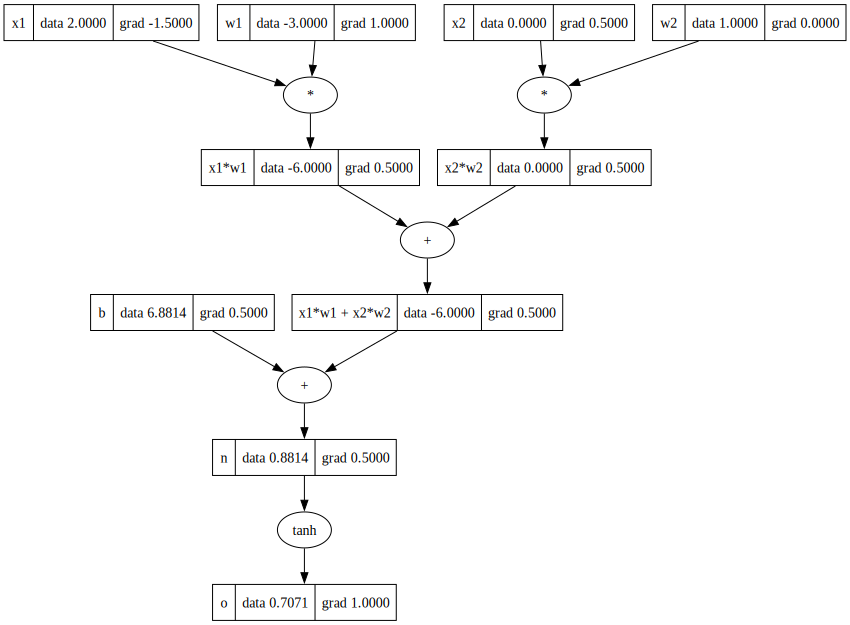

In [366]:
draw_dot(o)

it works!

Now we're going to implement some other mathematical operations and their `_backward` function

In [367]:
from __future__ import annotations
from typing import Callable, Tuple, Set, Union

class Value:
    def __init__(self, data: float, _children: Tuple[Value] = (), _op : str = '', label : str = ''):
        self.data = data
        self.grad = 0.0 # at initialization, we assume the variable does NOT affect the last value at all
        self.label = label

        #internal variables used for autograd graph construction
        self._prev = set(_children) # two children that led to the value
        self._op = _op # what operations created this value
        self._backward = lambda : None

    def __repr__(self) -> str:
        return f"Value(data={self.data})"
    
    def __add__(self, other: Value) -> Value:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other: Value) -> Value:
        other = other if isinstance(other, Value) else Value(other) # support ints/floats too
        out = Value(self.data*other.data, (self,other), '*')
        
        def _backward(): # define backprop step for multiplication
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def __pow__(self,other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other - 1)) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self/ other
        return self * (other**-1)
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # other - self
        return self + (-other) 
    
    def __radd__(self, other): # other + self
        return self + other
    
    def tanh(self) -> Value:
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) +1)
        out = Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1- t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
    
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad # 0 if no activation, else propagate out grad
        out._backward = _backward
        
        return out
    
    def backward(self) -> None:
        topo = []
        visited = set()

        def build_topo(v: Value) -> None:
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [368]:
a = Value(2.0)
b = Value(4.0)
a ** -1  *b

Value(data=2.0)

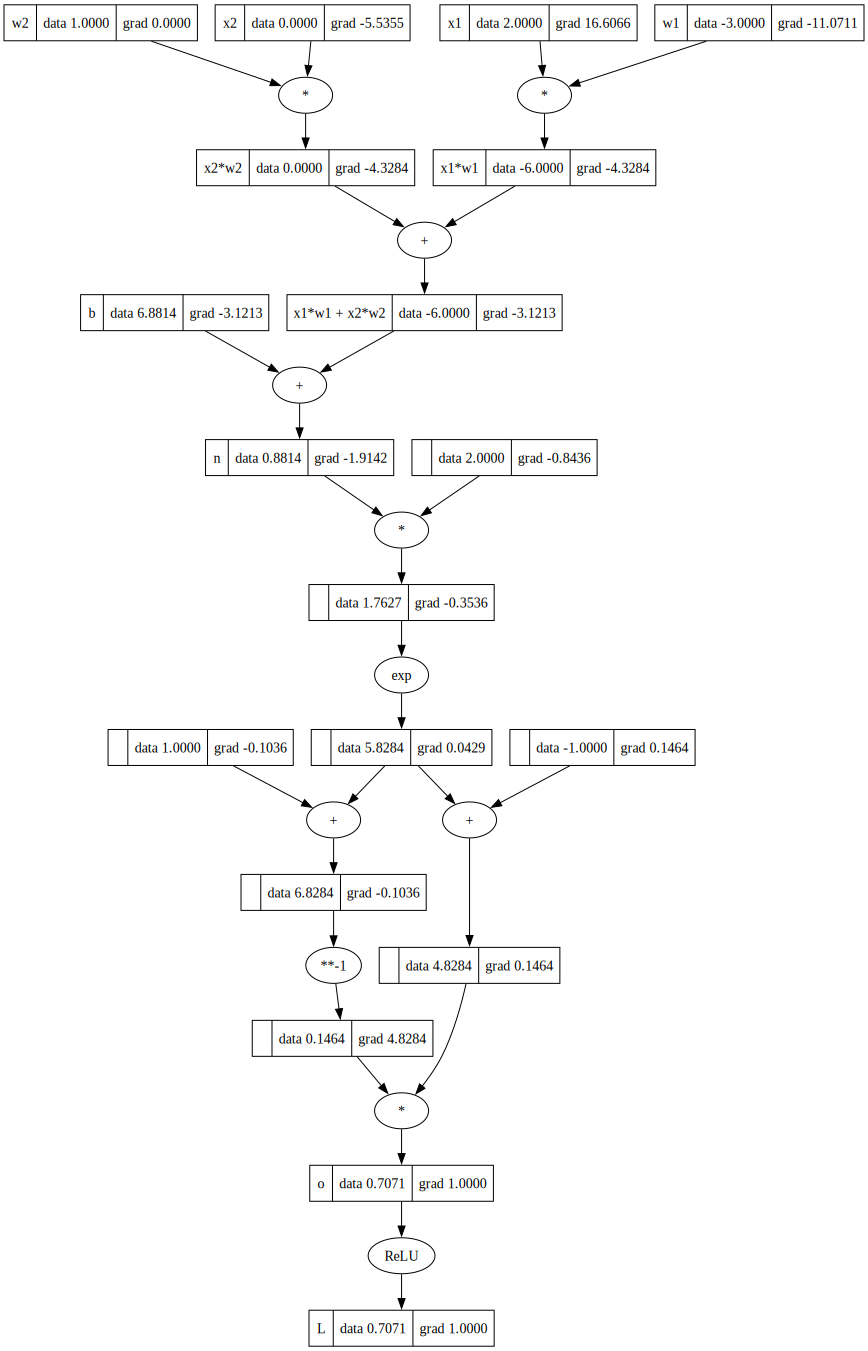

In [369]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
L = o.relu()
L.label = 'L'
L.backward()
draw_dot(L)

In [370]:

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label = ''):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
      
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
    
        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

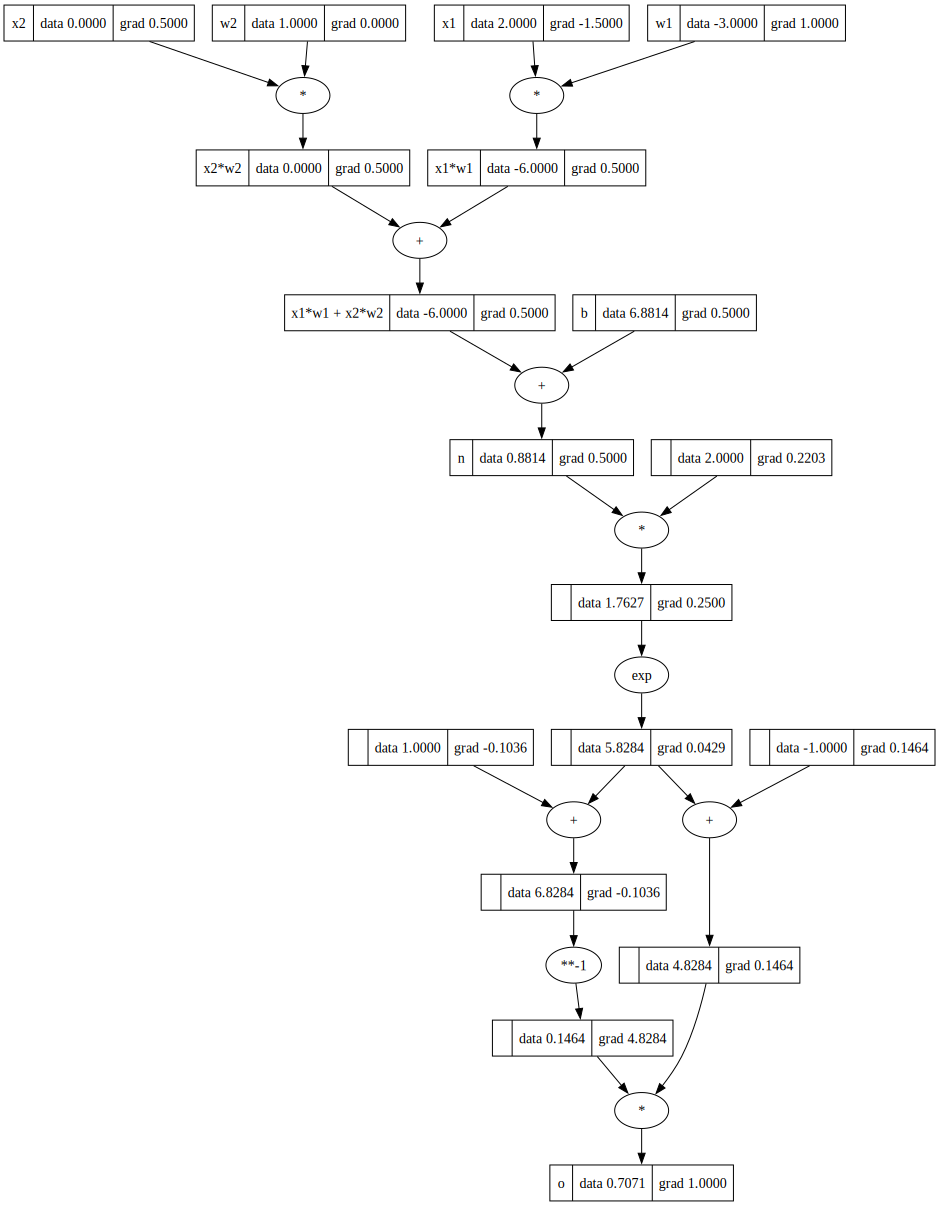

In [371]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'

o.backward()
draw_dot(o)



## Part 3. Pytorch

now, instead of scalar values, we're working with tensors

In [372]:
import torch
import random

In [373]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [374]:

x1 = torch.Tensor([2.0])                ; x1.requires_grad = True
x2 = torch.Tensor([0.0])                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0])               ; w1.requires_grad = True
w2 = torch.Tensor([1.0])                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432])  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071067094802856
---
x2 0.5000001192092896
w2 0.0
x1 -1.5000003576278687
w1 1.000000238418579


In [375]:
o.item()

0.7071067094802856

In [376]:
b.grad

tensor([0.5000])

## Neural networks

In [377]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w* x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh() # nonlinearity
        return out
    
    def parameters(self) -> list:
        return self.w + [self.b]
    


In [378]:
n = Neuron(7)
print(n.w, n.b)
n(np.ones(7))

[Value(data=0.9691353665191755, grad=0), Value(data=-0.4428594856663082, grad=0), Value(data=0.5091455195266783, grad=0), Value(data=0.22001561968992966, grad=0), Value(data=0.5213056178842925, grad=0), Value(data=0.9833553368073367, grad=0), Value(data=0.49759261296238577, grad=0)] Value(data=0.47073251401240235, grad=0)


Value(data=0.9988457174891677, grad=0)

In [379]:
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons] # call each neuron on the input
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [380]:
l1 = Layer(7, 2)
l1(np.ones(7))

[Value(data=0.845371200917333, grad=0),
 Value(data=-0.021533159193900718, grad=0)]

In [381]:
class MLP:
    def __init__(self, nin: int, nouts: list[int]):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [382]:
nn = MLP(3, [4,4,1])

nn.layers
x= [2.0,3.0,-1.0]
nn(x)

Value(data=0.5319704922813632, grad=0)

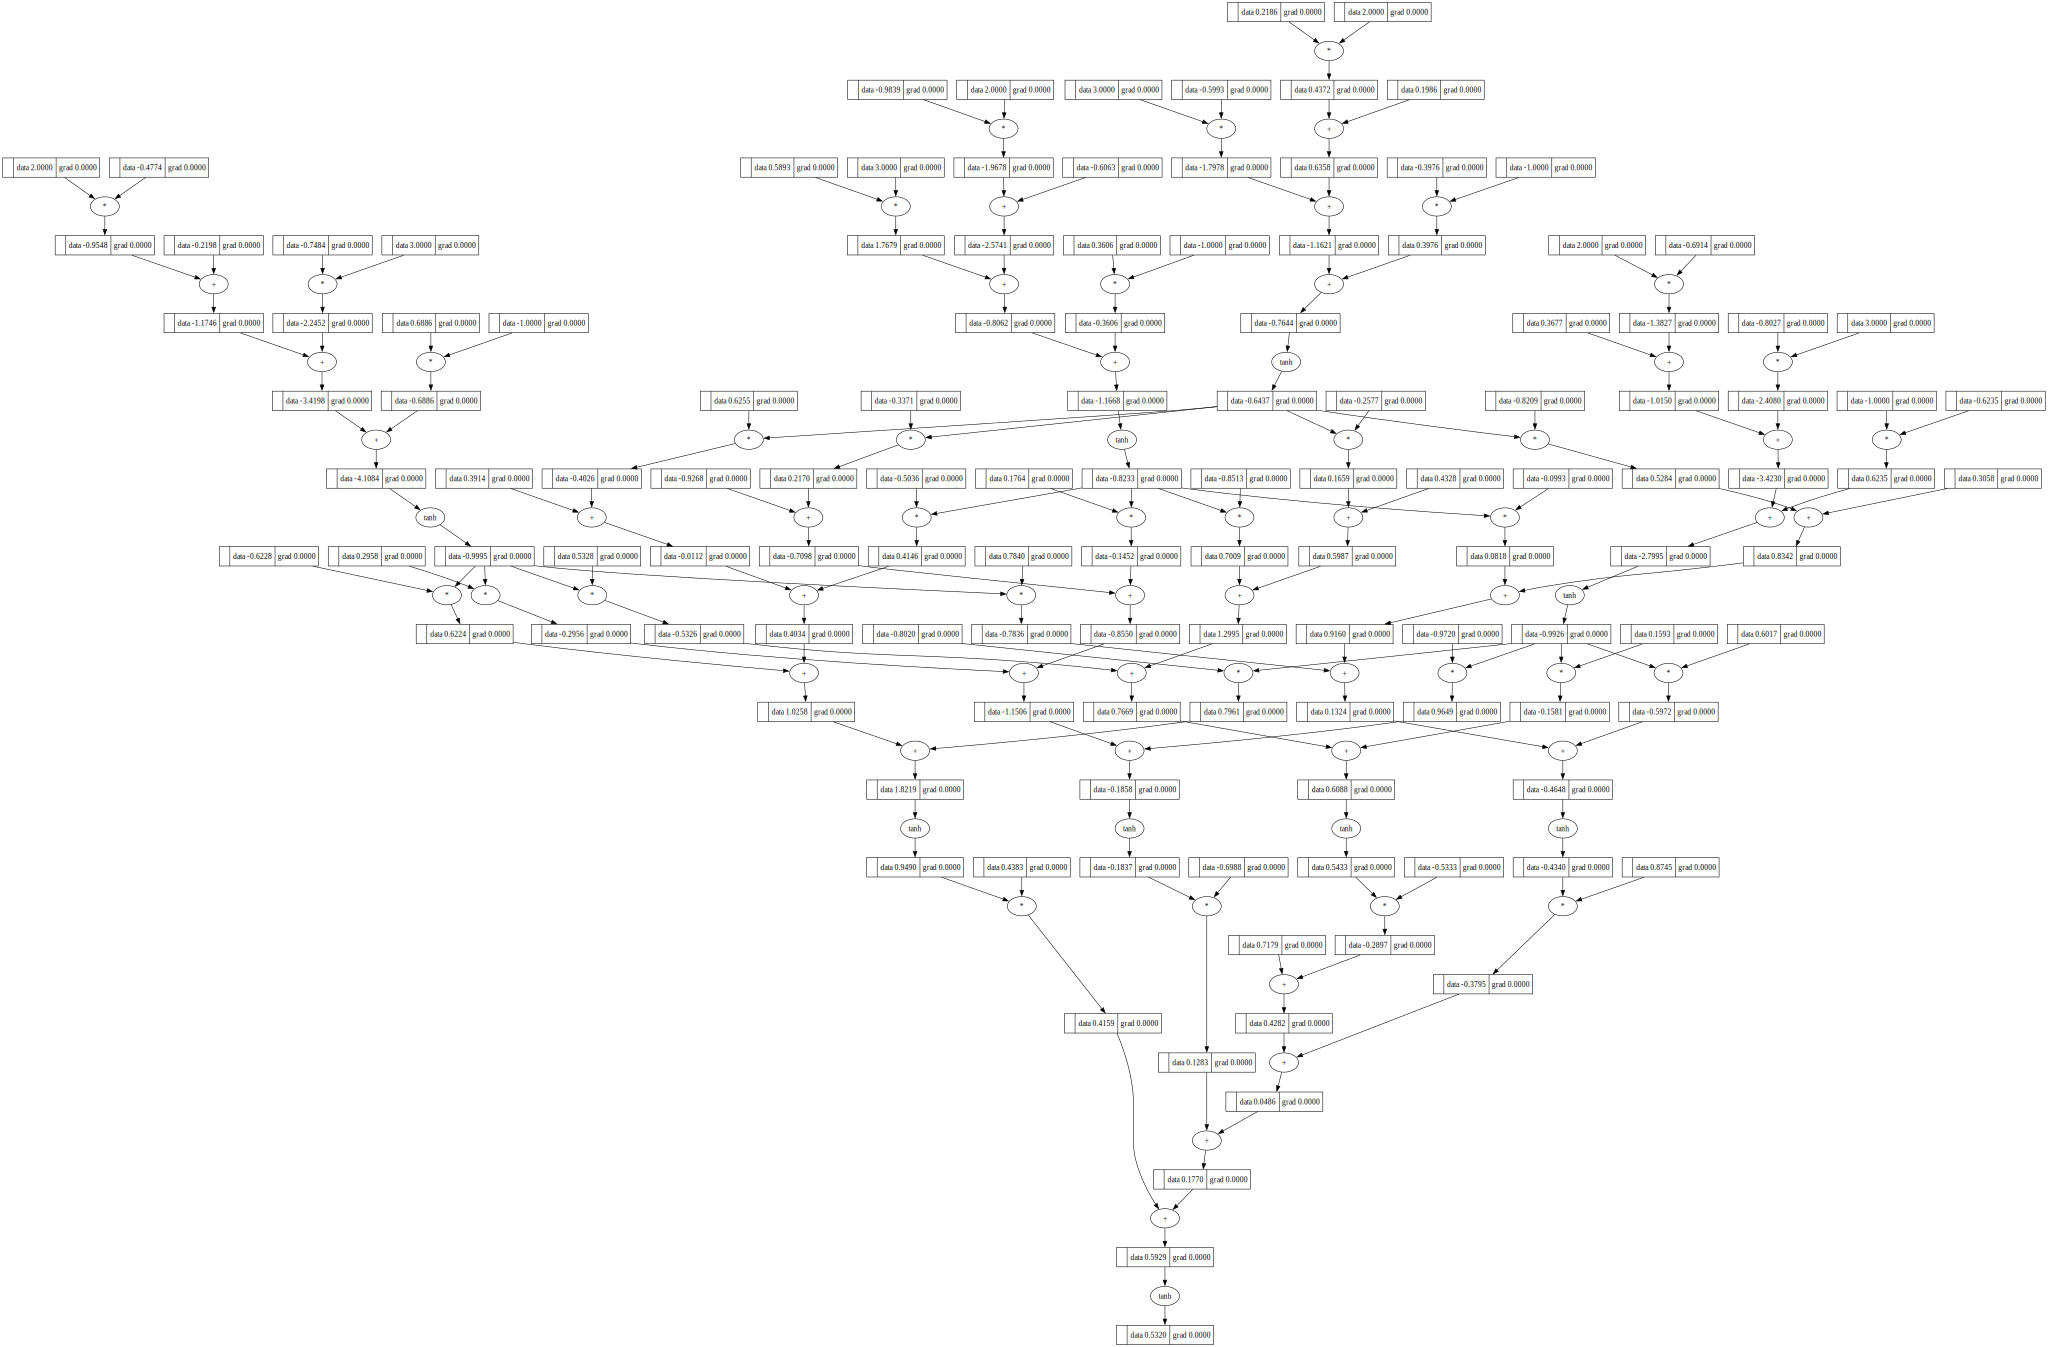

In [383]:
draw_dot(nn(x))

In [384]:
# example dataset
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [385]:
# current (untrained outputs)

ypred = [n(x) for x in xs]
ypred

[Value(data=0.516298160937617, grad=0),
 Value(data=0.9994233545211831, grad=0),
 Value(data=0.7705118280370717, grad=0),
 Value(data=0.4525185781456512, grad=0)]

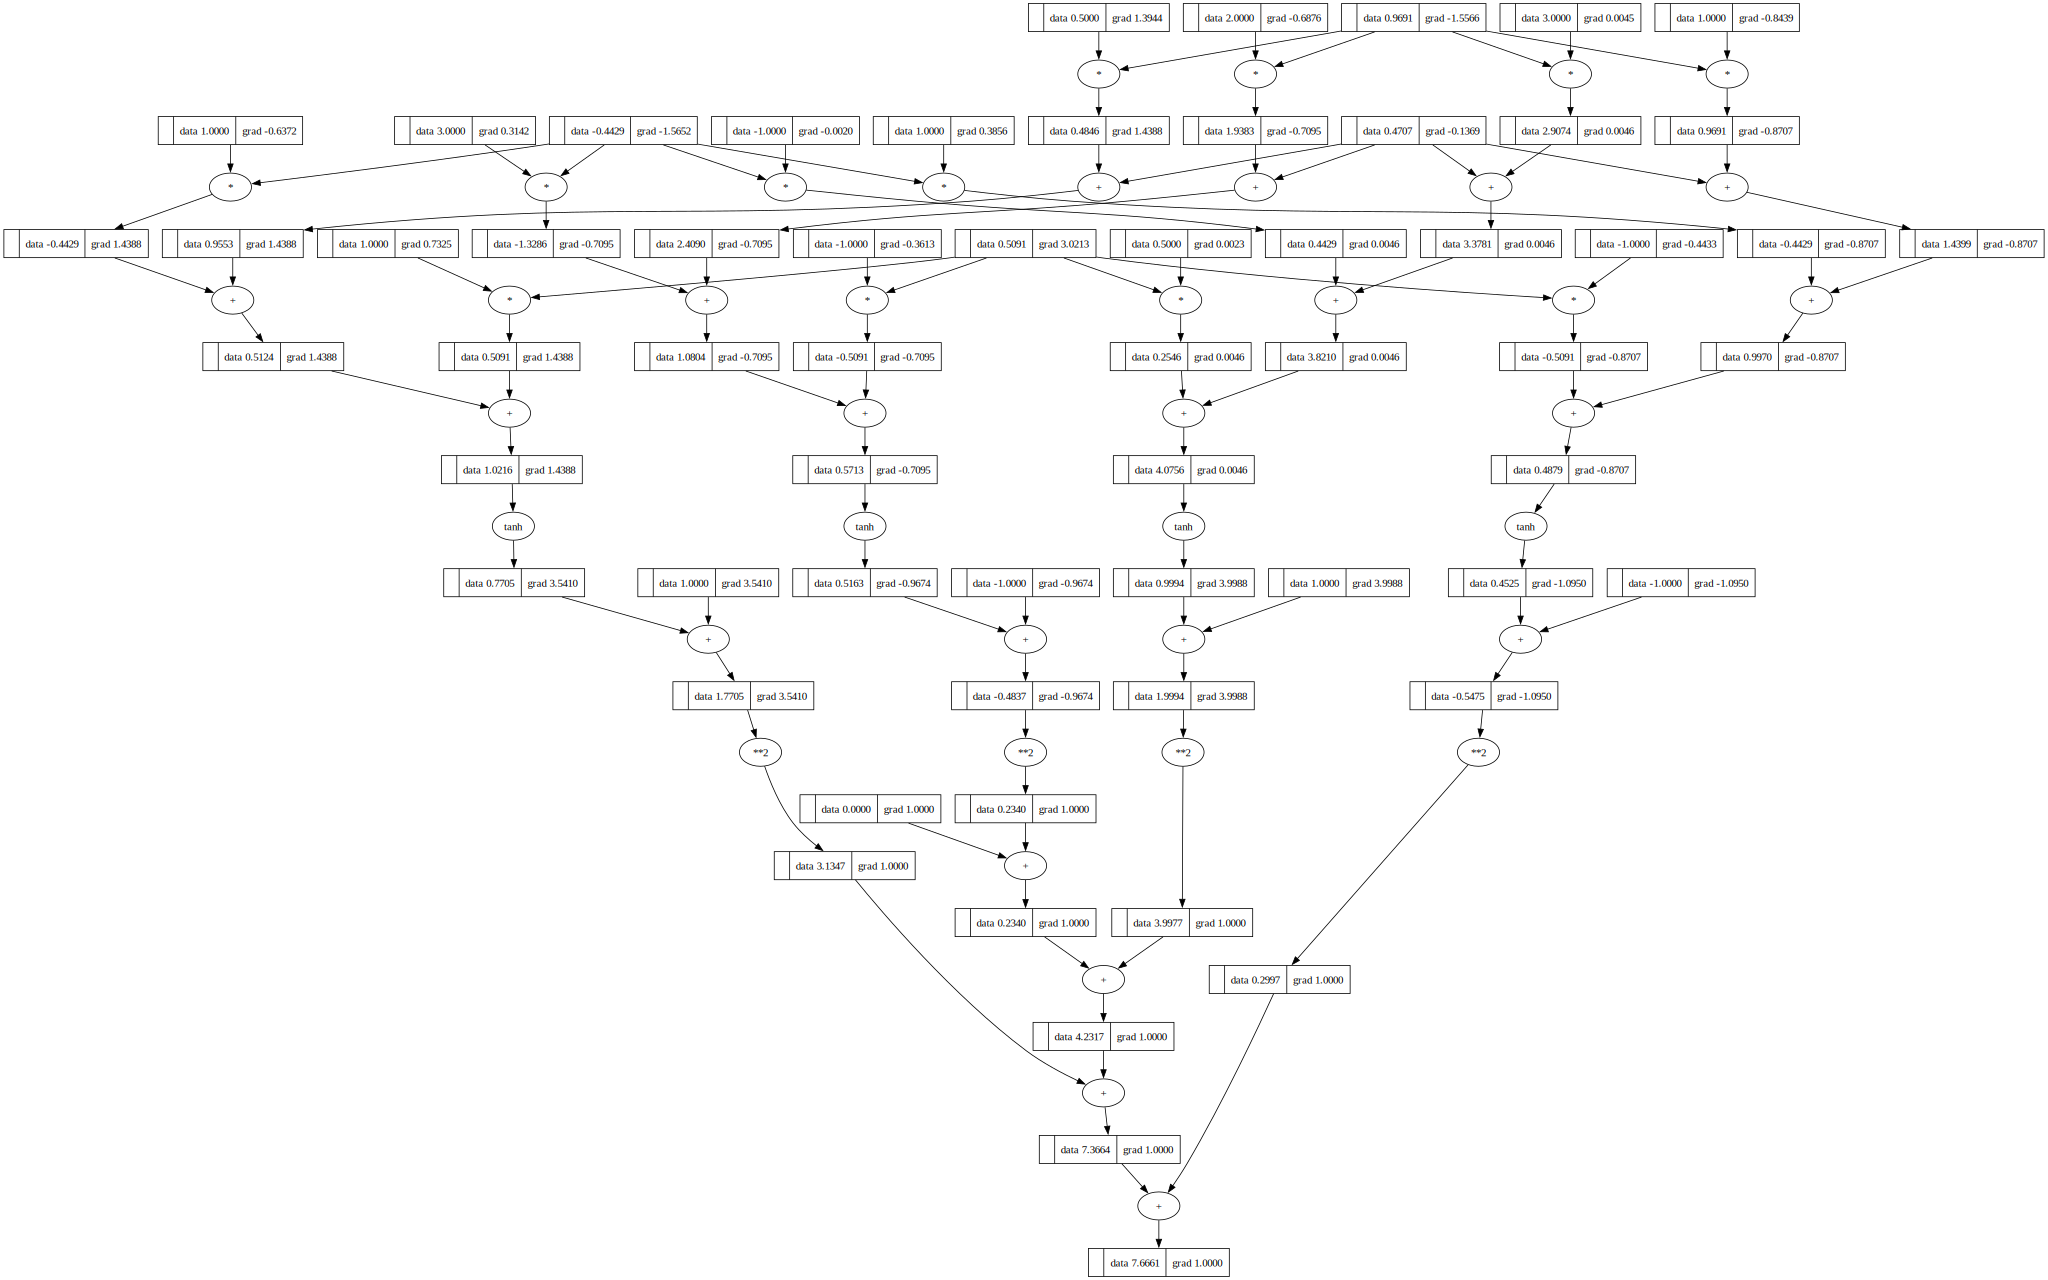

In [386]:
loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred)) # MSE for truth vs prediction
loss.backward()
draw_dot(loss)

In [393]:
LEARNING_RATE = 1e-1
n = MLP(3, [4,4,1])
# training
for it in range(1001):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred)) # MSE for truth vs prediction

    #backward pass
    for p in n.parameters():
        p.grad = 0.0 # REINITIALIZE parameters o 0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -LEARNING_RATE * p.grad
    
    if it % 50 == 0:
        print(f"Iteration {it}: loss {loss.data}")


Iteration 0: loss 8.321305848001787
Iteration 50: loss 0.011199313370768646
Iteration 100: loss 0.004706481840853583
Iteration 150: loss 0.0028389971954852246
Iteration 200: loss 0.00198473069956547
Iteration 250: loss 0.0015045684581789223
Iteration 300: loss 0.0012006349511980217
Iteration 350: loss 0.0009926761775085253
Iteration 400: loss 0.000842322145759973
Iteration 450: loss 0.0007290506400395641
Iteration 500: loss 0.000640949175397575
Iteration 550: loss 0.0005706564693752712
Iteration 600: loss 0.0005133928968503741
Iteration 650: loss 0.00046592791194444475
Iteration 700: loss 0.00042600411072834474
Iteration 750: loss 0.0003919992396239407
Iteration 800: loss 0.0003627192243516185
Iteration 850: loss 0.000337266764978458
Iteration 900: loss 0.00031495527061010996
Iteration 950: loss 0.00029525094230972753
Iteration 1000: loss 0.00027773285966248474


In [394]:
ypred

[Value(data=0.9926465079220861, grad=-0.01470698415582783),
 Value(data=-0.9997147363092159, grad=0.0005705273815681533),
 Value(data=-0.9897254273613977, grad=0.02054914527720464),
 Value(data=0.9891367226104022, grad=-0.021726554779195606)]

In [396]:
len(n.parameters())

41

In [400]:
for layer in n.layers:
    print(len(layer.parameters()))

16
20
5


In [405]:
def number_of_parameters(nin : int, nouts : list[int]) -> int:
    sz = [nin] + nouts
    return sum([((sz[i] + 1)*sz[i+ 1]) for i in range(len(nouts))])

In [407]:
number_of_parameters(3, [64,64,1])

4481